In [1]:
import os 
import numpy as np
import pandas as pd

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
import seaborn as sns
# import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager # to solve: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.

import scanpy as sc

In [3]:
import sys
sys.path.append('../../')

import utils

# Config

In [19]:
# set global rc parameters
utils.config_rc(dpi=300, font_size=6)
# mpl.rcParams
wk_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))

In [5]:
# multisection data result root path
data_root = utils.get_path('multisection_wk_root_path', json_path=os.path.join(wk_root, '_data.json'))

# All samples

In [6]:
sample_ids_1515 = ['151507', '151508', '151509', '151510']
_data_path_1515 = os.path.join(data_root,"DLPFC/DLPFC_1515_07_10/")
_best_list_1515 = ["SpaSEG_clusters","X_Harmony_leiden_0.7","H_liger_leiden_0.45"]

sample_ids_6972 = ['151669', '151670', '151671', '151672']
_data_path_6972 = os.path.join(data_root,"DLPFC/DLPFC_1516_69_72/")
_best_list_6972 = ["SpaSEG_clusters","X_Harmony_leiden_0.65","H_liger_leiden_0.2"]

sample_ids_7376 = ['151673','151674','151675','151676'] 
_data_path_7376 = os.path.join(data_root,"DLPFC/DLPFC_1516_73_76/")
_best_list_7376 = ["SpaSEG_clusters","X_Harmony_leiden_0.75","H_liger_leiden_0.3"]

title_list=["SpaSEG",'Harmony','LIGER']


In [7]:
# all methods ressults
_results_1515 = os.path.join(_data_path_1515,'merge_all.h5ad')
_results_6972 = os.path.join(_data_path_6972,'merge_all.h5ad')
_results_7376 = os.path.join(_data_path_7376,'merge_all.h5ad')

In [8]:
adata_1515 = sc.read_h5ad(_results_1515)
adata_6972 = sc.read_h5ad(_results_6972)
adata_7376 = sc.read_h5ad(_results_7376)

In [9]:
def _ari_nmi(sample_ids, adata, best_list, method_list):
    
    _df = None
    
    for i, _sample_id in enumerate(sample_ids):
        _adata = adata[adata.obs['batch']==_sample_id]
        ground_truth = _adata.obs['celltype'].astype("category").cat.codes.values
        
        ari = []
        nmi = []
        method = []
        for _label,_method in zip(best_list,method_list):
            _clusters = _adata.obs[_label].values
            
            _ari = adjusted_rand_score(ground_truth,_clusters)
            _nmi = normalized_mutual_info_score(ground_truth,_clusters)
            
            ari.append(_ari)
            nmi.append(_nmi)
            method.append(_method)
            
        _df_tmp = pd.DataFrame({
            'sample_id':[_sample_id] * len(best_list),
            'ARI':ari,
            'NMI':nmi,
            'method':method
        })
        if i == 0:
            _df = _df_tmp
        else:
            _df = pd.concat([_df, _df_tmp], axis=0)
            
    return _df
        

In [10]:
df_1515 = _ari_nmi(sample_ids_1515, adata_1515, _best_list_1515, title_list)
df_6972 = _ari_nmi(sample_ids_6972, adata_6972, _best_list_6972, title_list)
df_7376 = _ari_nmi(sample_ids_7376, adata_7376, _best_list_7376, title_list)

In [11]:
df_merge = pd.concat([df_1515, df_6972, df_7376], axis=0)

In [12]:
df_merge.to_csv(os.path.join(wk_root, f"notebook/results/Multisection/all_baseline_ari_nmi.csv"), index=False)

In [13]:
df_merge = pd.read_csv(os.path.join(wk_root, f"notebook/results/Multisection/all_baseline_ari_nmi.csv"))

In [14]:
df_merge[['method', 'ARI', 'NMI']].groupby('method').agg(['min','max','mean','median','std'])

ARI                                              NMI            \
              min       max     mean    median       std       min       max   
method                                                                         
Harmony  0.240745  0.460444  0.34247  0.330061  0.085350  0.333133  0.522782   
LIGER    0.040393  0.289963  0.17440  0.200940  0.079098  0.072901  0.381744   
SpaSEG   0.447124  0.848359  0.61170  0.585565  0.138660  0.635986  0.769243   

                                       
             mean    median       std  
method                                 
Harmony  0.410237  0.379524  0.074842  
LIGER    0.250956  0.278900  0.089146  
SpaSEG   0.679810  0.675639  0.036749

In [35]:
from statannotations.Annotator import Annotator
bg_f = ['#ffb482', '#8de5a1','#fab0e4' , '#d0bbff', '#debb9b', '#ff9f9b', '#cfcfcf', '#fffea3', '#b9f2f0']
ln_f = ['#ff7c00', '#1ac938','#f14cc1' , '#8b2be2', '#9f4800', '#e8000b', '#a3a3a3', '#ffc400', '#00d7ff']
def _boxplot(data, x, y, orders, ax, bg_f, ln_f,comp_pairs, showfliers=True):
    
    plot_param={
        'data':data,
        'x':x,
        'y':y,
        'order':orders
    }
    
    palette = dict(zip(orders, bg_f))
    
    sns.stripplot(**plot_param, ax = ax,palette=dict(zip(orders, ln_f)),size=2)
    
    axa = sns.boxplot(**plot_param,
                          ax=ax, palette=palette,
                          showfliers=showfliers, 
                          flierprops={"marker": ".",'markersize': 1},
                          linewidth=0.8,
                          width=0.6,saturation=0.6,showcaps=True)
    
    for i,artist in enumerate(ax.patches): #In matplotlib 3.5 the boxes are stored in ax.patches instead of ax.artists.
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        # col = artist.get_facecolor()
        # artist.set_edgecolor(col)
        # artist.set_facecolor('None')
        artist.set_edgecolor(ln_f[i])
    
        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            # line.set_color(col)
            # line.set_mfc(col)
            # line.set_mec(col)

            line.set_color(ln_f[i])
            line.set_mfc(ln_f[i])
            line.set_mec(ln_f[i])
    annot = Annotator(axa, pairs=comp_pairs, **plot_param)
    annot.configure(test='Mann-Whitney', comparisons_correction="BH", text_format='star', 
                    line_width=0.5,fontsize=5,loc='inside',line_height=0.03, text_offset=0.5)
    annot.apply_and_annotate()
    
    
#     xticklabels = axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
#     for i, xticklabel in enumerate(xticklabels):
#         xticklabel.set_y(xticklabel.get_position()[1] +  0.01)
    axa.tick_params(direction='out', length=3, pad=3, width=1)
#     plt.grid(color='0.9',linewidth=0.5)
    sns.despine()
    plt.xlabel(None)
    plt.ylabel(None)

    return axa

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SpaSEG vs. Harmony: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.006e-05 U_stat=1.420e+02
SpaSEG vs. LIGER: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.658e-05 U_stat=1.440e+02


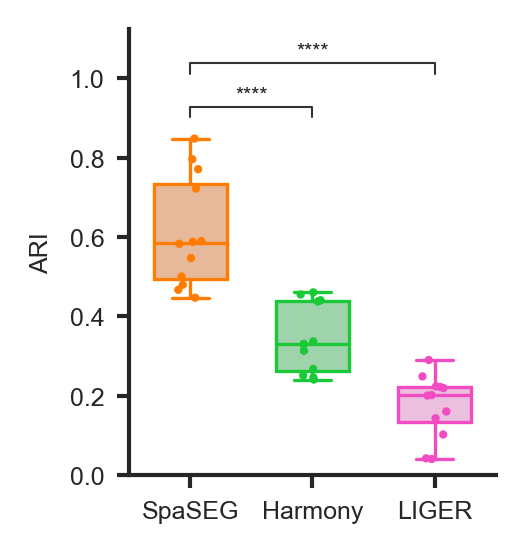

In [36]:
fig,ax = plt.subplots(figsize=(utils.centimeter*4, utils.centimeter*5))
axa=_boxplot(df_merge, 'method', 'ARI', title_list, ax, 
             bg_f[:len(title_list)], ln_f[:len(title_list)],
             comp_pairs = [("SpaSEG","Harmony"),("SpaSEG","LIGER")],showfliers=False)
ax.set_xticklabels(["SpaSEG",'Harmony','LIGER'])
ax.set_ylabel('ARI')
plt.savefig(os.path.join(wk_root, f"notebook/results/Multisection/Supp_baseline_All_ARI.pdf"), bbox_inches='tight', format='pdf', dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SpaSEG vs. Harmony: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.658e-05 U_stat=1.440e+02
SpaSEG vs. LIGER: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.658e-05 U_stat=1.440e+02


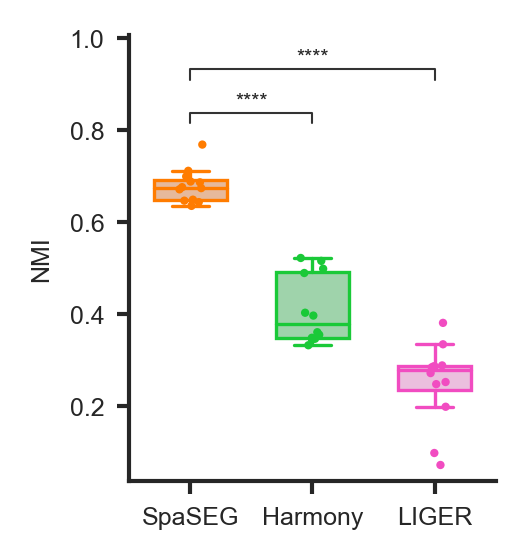

In [37]:
fig,ax = plt.subplots(figsize=(utils.centimeter*4, utils.centimeter*5))
axa=_boxplot(df_merge, 'method', 'NMI', title_list, ax, 
             bg_f[:len(title_list)], ln_f[:len(title_list)],
             comp_pairs = [("SpaSEG","Harmony"),("SpaSEG","LIGER")],showfliers=False)
ax.set_xticklabels(["SpaSEG",'Harmony','LIGER'])
ax.set_ylabel('NMI')
plt.savefig(os.path.join(wk_root, f"notebook/results/Multisection/Supp_baseline_All_NMI.pdf"), bbox_inches='tight', format='pdf', dpi=400)

# Compare SpaSEG before and after merge 

In [26]:
before_ari = pd.read_csv(os.path.join(wk_root, "notebook/results/Baseline/baseline_ari.csv"),index_col=0)
before_nmi = pd.read_csv(os.path.join(wk_root, "notebook/results/Baseline/baseline_nmi.csv"),index_col=0)
before_ari = before_ari.reset_index(names=['sample_id'])
before_ari['sample_id'] = before_ari['sample_id'].astype(str) 
before_nmi = before_nmi.reset_index(names=['sample_id'])
before_nmi['sample_id'] = before_nmi['sample_id'].astype(str) 

In [27]:
before = before_ari[['sample_id','SpaSEG']].copy()
before.rename(columns={"SpaSEG": "ARI"},inplace=True)
before['NMI'] = before_nmi['SpaSEG']
before['method'] = 'Single'

In [28]:
before

,sample_id,ARI,NMI,method
0,151507,0.435099,0.634496,Single
1,151508,0.489334,0.621860,Single
2,151509,0.468462,0.642574,Single
3,151510,0.527943,0.651253,Single
4,151669,0.592084,0.643080,Single
5,151670,0.665319,0.601756,Single
6,151671,0.519948,0.630649,Single
7,151672,0.525555,0.632555,Single
8,151673,0.553867,0.673818,Single
9,151674,0.561247,0.671428,Single


In [29]:
after = df_merge[df_merge['method']=='SpaSEG'].copy()
after['method'] = 'Integrative'

In [30]:
after

,sample_id,ARI,NMI,method
0,151507,0.447124,0.649481,Integrative
3,151508,0.466904,0.644188,Integrative
6,151509,0.479738,0.647298,Integrative
9,151510,0.500480,0.635986,Integrative
12,151669,0.771086,0.676691,Integrative
15,151670,0.796121,0.674588,Integrative
18,151671,0.848359,0.769243,Integrative
21,151672,0.722284,0.712205,Integrative
24,151673,0.589922,0.671994,Integrative
27,151674,0.583069,0.699970,Integrative


In [31]:
SpaSEG_be_af = pd.concat([before, after])

In [32]:
SpaSEG_be_af[['method', 'ARI', 'NMI']].groupby('method').agg(['min','max','mean','median','std'])

ARI                                               NMI  \
                  min       max      mean    median       std       min   
method                                                                    
Integrative  0.447124  0.848359  0.611700  0.585565  0.138660  0.635986   
Single       0.435099  0.665319  0.532147  0.526749  0.060545  0.601756   

                                                     
                  max      mean    median       std  
method                                               
Integrative  0.769243  0.679810  0.675639  0.036749  
Single       0.673818  0.643789  0.642827  0.021390

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Single vs. Integrative: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.366e-01 U_stat=5.100e+01


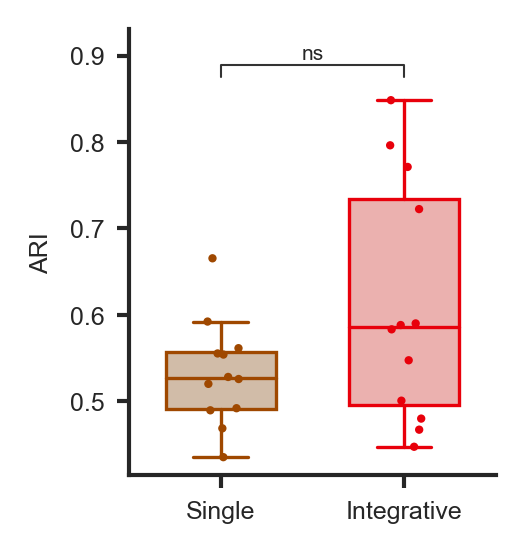

In [38]:
fig,ax = plt.subplots(figsize=(utils.centimeter*4, utils.centimeter*5))
axa=_boxplot(SpaSEG_be_af, 'method', 'ARI', ["Single","Integrative"], ax, 
             bg_f[4:6], ln_f[4:6],
             comp_pairs = [("Single","Integrative")],showfliers=False)
ax.set_xticklabels(["Single","Integrative"])
ax.set_ylabel('ARI')
plt.savefig(os.path.join(wk_root, f"notebook/results/Multisection/Supp_baseline_SpaSEG_before_after_ARI.pdf"), bbox_inches='tight', format='pdf', dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Single vs. Integrative: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.108e-03 U_stat=2.300e+01


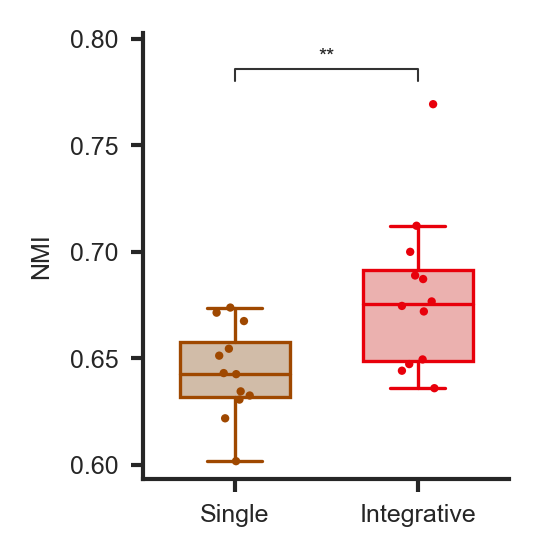

In [39]:
fig,ax = plt.subplots(figsize=(utils.centimeter*4, utils.centimeter*5))
axa=_boxplot(SpaSEG_be_af, 'method', 'NMI', ["Single","Integrative"], ax, 
             bg_f[4:6], ln_f[4:6],
             comp_pairs = [("Single","Integrative")],showfliers=False)
ax.set_xticklabels(["Single","Integrative"])
ax.set_ylabel('NMI')
plt.savefig(os.path.join(wk_root, f"notebook/results/Multisection/Supp_baseline_SpaSEG_before_after_NMI.pdf"), bbox_inches='tight', format='pdf', dpi=400)